# Single-Objective Optimisation in Ms. Pac-Man using a Genetic Algorithm

This notebook takes the results from SOO runs using different combinations of parameters. Metrics from convergence analysis, population convergence computational efficiency, relative improvement rates and selection pressures were able to be measured on multiple runs in order to measure the effects on overall performance. 


In [1]:
# import libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import datetime

## Defining the analyser class
For statistical analysis of experiment runs of Ms. Pac-Man games.

In [2]:
# Define the analyser class
class MsPacmanGAAnalyser:
    def __init__(self):
        self.experiments = {}
        self.combined_data = None
        
    def load_experiment(self, filepath, params):
        """Load a single game run experiment result and its parameters"""
        with open(filepath, 'rb') as f:
            results = pickle.load(f)
            
        exp_name = f"exp_{len(self.experiments)}"
        self.experiments[exp_name] = {
            'results': results,
            'params': params,
            'data': results['generation_data']
        }
        
        # Add parameter columns and additional metrics
        data = self.experiments[exp_name]['data']
        data = data.assign(**params)
        data['experiment'] = exp_name
        
        # Calculate additional metrics specific to Ms. Pac-Man
        data['Learning_Rate'] = data['Max Fitness'].diff() / data['Max Fitness'].shift(1)
        data['Population_Efficiency'] = (data['Max Fitness'] - data['Avg Fitness']) / data['Max Fitness']
        data['Computational_Cost'] = data['Max Time Taken (s)'] / data['Max Fitness']
        data['Exploration_Rate'] = (data['Max Fitness'] - data['Avg Fitness']) / data['Max Fitness']
        
        self.experiments[exp_name]['data'] = data
        self.experiments[exp_name]['best_individual'] = results['best_individual']
        self.experiments[exp_name]['best_seed'] = results['best_seed']
        self.experiments[exp_name]['top_10_individuals'] = results['top_10_individuals']
        self.experiments[exp_name]['top_10_fitness_values'] = results['top_10_fitness_values']
        
        if self.combined_data is None:
            self.combined_data = data
        else:
            self.combined_data = pd.concat([self.combined_data, data], ignore_index=True)
    
    def perform_statistical_analysis(self):
        """Perform statistical tests focused on Ms. Pac-Man performance metrics"""
        results = {}
        params = [col for col in self.combined_data.columns 
                 if col in ['population_size', 'sequence_length', 'mutation_rate', 
                           'crossover_rate', 'tournament_size']]
        
        for param in params:
            groups = [group['Max Fitness'].values 
                     for name, group in self.combined_data.groupby(param)]
            h_stat, p_value = stats.kruskal(*groups)
            results[param] = {
                'test': 'Kruskal-Wallis H',
                'statistic': h_stat,
                'p_value': p_value
            }
        
        metrics = ['Max Fitness', 'Population_Efficiency', 'Learning_Rate', 
                  'Computational_Cost', 'Exploration_Rate']
        corr_matrix = self.combined_data[params + metrics].corr()
        
        return {
            'parameter_tests': pd.DataFrame(results).T,
            'correlation_matrix': corr_matrix
        }
    
    def plot_learning_curves(self):
        """Plot detailed learning curves with exploration metrics"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        for exp_name, exp_data in self.experiments.items():
            data = exp_data['data']
            params_str = ', '.join([f'{k}={v}' for k, v in exp_data['params'].items()])
            
            ax1.plot(data['Generation'], data['Max Fitness'], 
                    label=f'{exp_name} ({params_str})')
            ax1.fill_between(data['Generation'],
                           data['Avg Fitness'],
                           data['Max Fitness'],
                           alpha=0.2)
            
            ax2.plot(data['Generation'], data['Exploration_Rate'],
                    label=f'{exp_name} ({params_str})')
        
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Fitness')
        ax1.set_title('Learning Curves with Population Spread')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        ax2.set_xlabel('Generation')
        ax2.set_ylabel('Exploration Rate')
        ax2.set_title('Population Exploration Over Time')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        

    def generate_summary_table(self):
        """Generate enhanced summary statistics specific to Ms. Pac-Man"""
        summary_data = []

        for exp_name, exp_data in self.experiments.items():
            data = exp_data['data']
            max_fitness = data['Max Fitness'].max()

            # Calculate convergence generation 
            # Use rolling average to smooth out learning rate fluctuations
            window_size = 10  # Look at last 10 generations for smoother convergence detection
            convergence_threshold = 0.01  # 1% improvement threshold

            # Calculate smoothed learning rate
            smoothed_learning_rate = data['Learning_Rate'].rolling(window=window_size, min_periods=1).mean()

            # Find first generation where learning rate stays below threshold
            converged_gens = 0
            for i in range(len(smoothed_learning_rate) - window_size):
                if all(abs(smoothed_learning_rate.iloc[i:i+window_size]) < convergence_threshold):
                    converged_gens = i
                    break

            # If no convergence found, set to total generations
            if converged_gens == 0:
                converged_gens = len(data)

            summary = {
                'Experiment': exp_name,
                'Max Fitness': max_fitness,
                'Avg Fitness': data['Avg Fitness'].mean(),
                'Best Seed': exp_data['best_seed'],
                'Generations to Converge': converged_gens,
                'Convergence Fitness': data['Max Fitness'].iloc[min(converged_gens, len(data)-1)],
                'Final Fitness': data['Max Fitness'].iloc[-1],
                'Fitness Improvement After Convergence': (
                    data['Max Fitness'].iloc[-1] - 
                    data['Max Fitness'].iloc[min(converged_gens, len(data)-1)]
                ),
                'Avg Time per Gen (s)': data['Avg Time Taken (s)'].mean(),
                'Total Compute Time (h)': data['Max Time Taken (s)'].max() / 3600,
                'Final Exploration Rate': data['Exploration_Rate'].iloc[-1],
                'Avg Learning Rate': data['Learning_Rate'].mean(),
                **exp_data['params']
            }
            summary_data.append(summary)

        return pd.DataFrame(summary_data)

## Experiments and loading the data files
Defining the experiments run under specific parameters.


In [3]:
# Define experiments and load data
# Define experiments with filepaths and parameters
experiments = [
#     baseline
    {
        'filepath': 'runs_results/params_baseline/run_3/ms_pacman_ga_results_final.pkl',
        'params': {
            'population_size': 100,
            'sequence_length': 300,
            'mutation_rate': 0.05,
            'crossover_rate': 0.7,
            'tournament_size': 3
        }
    },
#     population size
    {
        'filepath': 'runs_results/params_1/run_2/ms_pacman_ga_results_final.pkl',
        'params': {
            'population_size': 50,
            'sequence_length': 300,
            'mutation_rate': 0.05,
            'crossover_rate': 0.7,
            'tournament_size': 3
        }
    },
#     sequence length
    {
        'filepath': 'runs_results/params_2/run_2/ms_pacman_ga_results_final.pkl',
        'params': {
            'population_size': 100,
            'sequence_length': 500,
            'mutation_rate': 0.05,
            'crossover_rate': 0.7,
            'tournament_size': 3
        }
    },
    {
        'filepath': 'runs_results/params_3/run_1/ms_pacman_ga_results_final.pkl',
        'params': {
            'population_size': 100,
            'sequence_length': 300,
            'mutation_rate': 0.1,
            'crossover_rate': 0.7,
            'tournament_size': 3
        }
    },
    {
        'filepath': 'runs_results/params_4/run_1/ms_pacman_ga_results_final.pkl',
        'params': {
            'population_size': 100,
            'sequence_length': 300,
            'mutation_rate': 0.05,
            'crossover_rate': 0.9,
            'tournament_size': 3
        }
    },
    {
        'filepath': 'runs_results/params_5/run_1/ms_pacman_ga_results_final.pkl',
        'params': {
            'population_size': 100,
            'sequence_length': 300,
            'mutation_rate': 0.05,
            'crossover_rate': 0.7,
            'tournament_size': 5
        }
    }
]

# Initialise analyser
analyser = MsPacmanGAAnalyser()

# Load each experiment
for exp in experiments:
    try:
        print(f"Loading {exp['filepath']}...")
        analyser.load_experiment(exp['filepath'], exp['params'])
    except FileNotFoundError:
        print(f"Warning: Could not find {exp['filepath']}")
    except Exception as e:
        print(f"Error loading {exp['filepath']}: {e}")

Loading /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/runs_results/params_baseline/run_3/ms_pacman_ga_results_final.pkl...
Loading /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/runs_results/params_1/run_2/ms_pacman_ga_results_final.pkl...
Loading /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/runs_results/params_2/run_2/ms_pacman_ga_results_final.pkl...
Loading /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/runs_results/params_3/run_1/ms_pacman_ga_results_final.pkl...
Loading /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/runs_results/params_4/run_1/ms_pacman_ga_results_final.pkl...
Loading /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/runs_results/params_5/run_1/ms_pacman_ga_results_final.pkl...


## Generate and display analysis


Generating analysis...

Plotting learning curves...


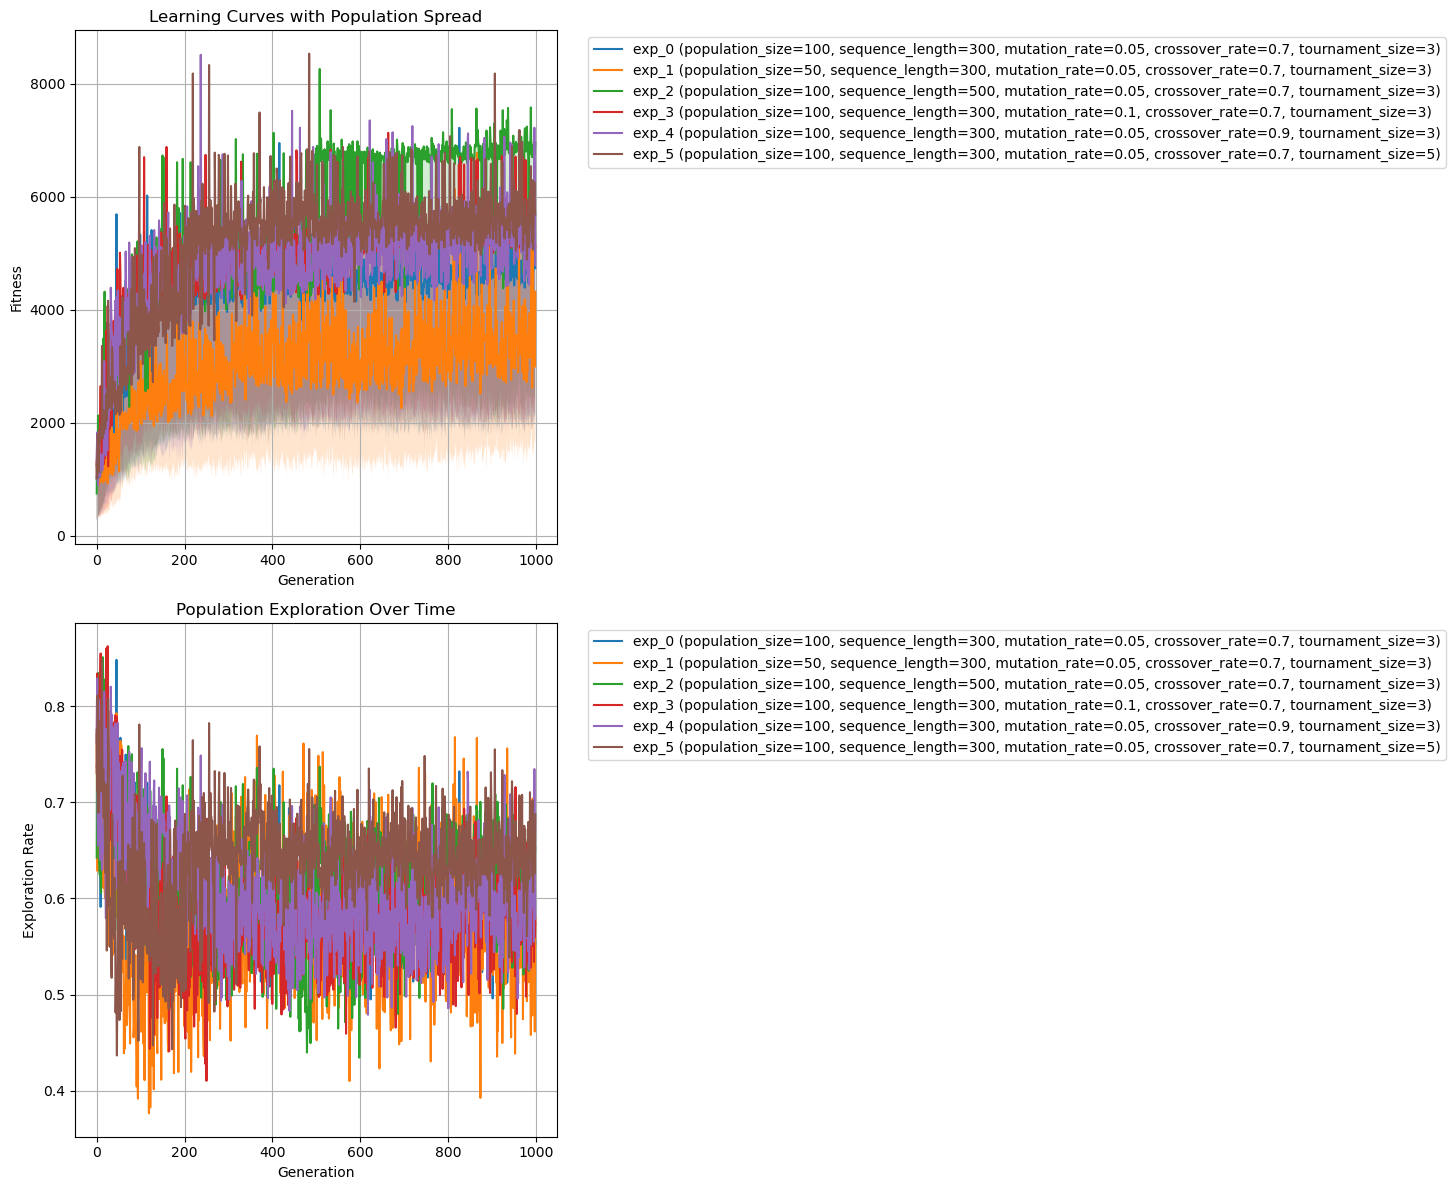

In [4]:
# Generate and display analysis
print("\nGenerating analysis...")

# Plot learning curves
print("\nPlotting learning curves...")
analyser.plot_learning_curves()

# Modify the perform_statistical_analysis method to handle single groups
def perform_statistical_analysis(self):
    """Perform statistical tests focused on Ms. Pac-Man performance metrics"""
    results = {}
    params = [col for col in self.combined_data.columns 
             if col in ['population_size', 'sequence_length', 'mutation_rate', 
                       'crossover_rate', 'tournament_size']]
    
    for param in params:
        # Get unique values for this parameter
        unique_values = self.combined_data[param].unique()
        
        if len(unique_values) < 2:
            # Not enough groups for statistical test
            results[param] = {
                'test': 'No test performed',
                'statistic': None,
                'p_value': None,
                'note': f'Only one value ({unique_values[0]}) present'
            }
        else:
            # Perform Kruskal-Wallis test
            groups = [group['Max Fitness'].values 
                     for name, group in self.combined_data.groupby(param)]
            try:
                h_stat, p_value = stats.kruskal(*groups)
                results[param] = {
                    'test': 'Kruskal-Wallis H',
                    'statistic': h_stat,
                    'p_value': p_value,
                    'note': f'{len(unique_values)} different values tested'
                }
            except Exception as e:
                results[param] = {
                    'test': 'Test failed',
                    'statistic': None,
                    'p_value': None,
                    'note': str(e)
                }
    
    metrics = ['Max Fitness', 'Population_Efficiency', 'Learning_Rate', 
              'Computational_Cost', 'Exploration_Rate']
    
    # Only include metrics that exist in the data
    available_metrics = [m for m in metrics if m in self.combined_data.columns]
    available_params = [p for p in params if p in self.combined_data.columns]
    
    # Calculate correlation matrix only if we have data
    if available_metrics and available_params:
        corr_matrix = self.combined_data[available_params + available_metrics].corr()
    else:
        corr_matrix = pd.DataFrame()
    
    return {
        'parameter_tests': pd.DataFrame(results).T,
        'correlation_matrix': corr_matrix
    }

MsPacmanGAAnalyser.perform_statistical_analysis = perform_statistical_analysis

In [5]:
# Perform statistical analysis
print("\nPerforming statistical analysis...")
stats_results = analyser.perform_statistical_analysis()
print("\nParameter Statistical Tests:")
display(stats_results['parameter_tests'])


Performing statistical analysis...

Parameter Statistical Tests:


,test,statistic,p_value,note
population_size,Kruskal-Wallis H,1842.61274,0.0,2 different values tested
sequence_length,Kruskal-Wallis H,396.935681,0.0,2 different values tested
mutation_rate,Kruskal-Wallis H,64.514134,0.0,2 different values tested
crossover_rate,Kruskal-Wallis H,24.284742,0.000001,2 different values tested
tournament_size,Kruskal-Wallis H,430.889219,0.0,2 different values tested



Correlation Matrix:


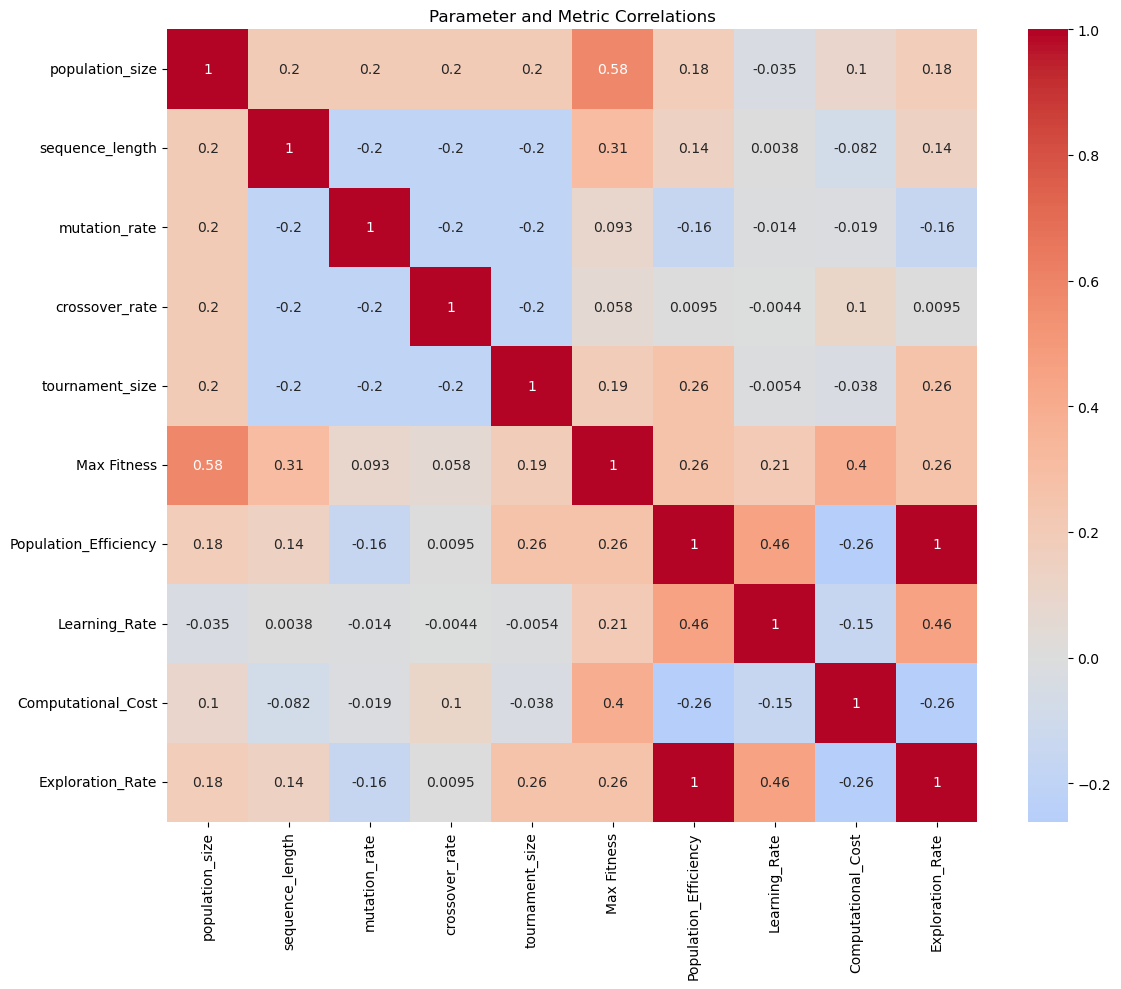

In [6]:
# Only show correlation matrix where there is data
if not stats_results['correlation_matrix'].empty:
    print("\nCorrelation Matrix:")
    plt.figure(figsize=(12, 10))
    sns.heatmap(stats_results['correlation_matrix'], annot=True, cmap='coolwarm', center=0)
    plt.title("Parameter and Metric Correlations")
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough variation in parameters to generate correlation matrix")

In [7]:
# Generate summary table
print("\nGenerating summary table...")
summary_df = analyser.generate_summary_table()
print("\nExperiment Summary:")
display(summary_df)


Generating summary table...

Experiment Summary:


,Experiment,Max Fitness,Avg Fitness,Best Seed,Generations to Converge,Convergence Fitness,Final Fitness,Fitness Improvement After Convergence,Avg Time per Gen (s),Total Compute Time (h),Final Exploration Rate,Avg Learning Rate,population_size,sequence_length,mutation_rate,crossover_rate,tournament_size
0,exp_0,7220.0,1816.7322,690047,180,4280.0,4740.0,460.0,6.996793,2.021310,0.554599,0.009955,100,300,0.05,0.7,3
1,exp_1,6780.0,1271.2594,839046,1000,4320.0,4320.0,0.0,3.596632,1.043989,0.581806,0.029237,50,300,0.05,0.7,3
2,exp_2,8260.0,2068.9433,947889,35,3590.0,6950.0,3360.0,6.898566,1.969449,0.652763,0.017154,100,500,0.05,0.7,3
3,exp_3,7130.0,2073.9312,39256,64,4230.0,5120.0,890.0,6.499841,1.858565,0.574961,0.010217,100,300,0.10,0.7,3
4,exp_4,8510.0,1912.6552,523592,640,5420.0,4790.0,-630.0,7.321733,2.097756,0.578643,0.013938,100,300,0.05,0.9,3
5,exp_5,8530.0,1842.1167,936438,627,5870.0,5690.0,-180.0,6.794699,1.902894,0.687645,0.013560,100,300,0.05,0.7,5



Generating additional visualizations...


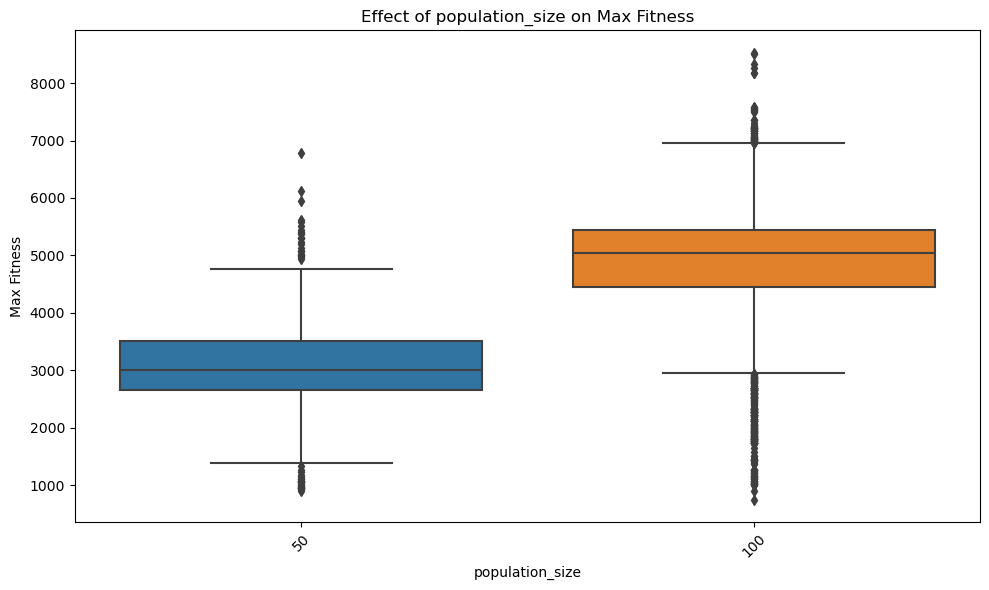

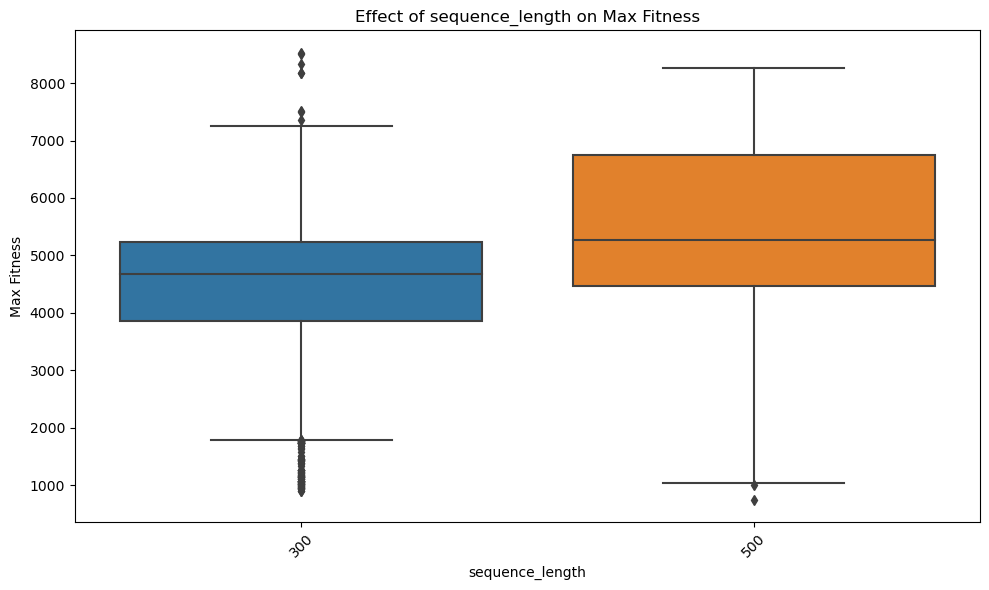

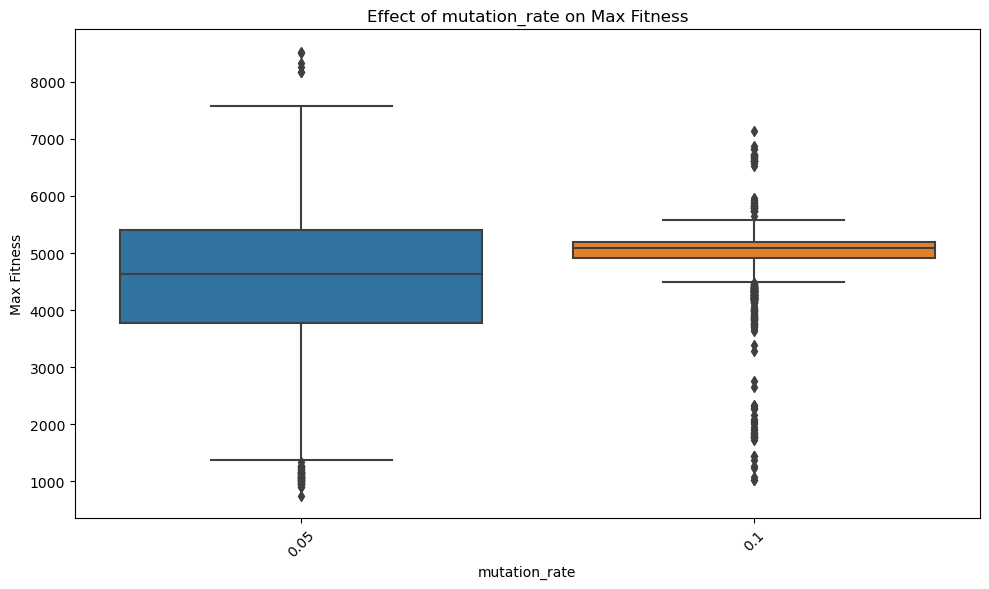

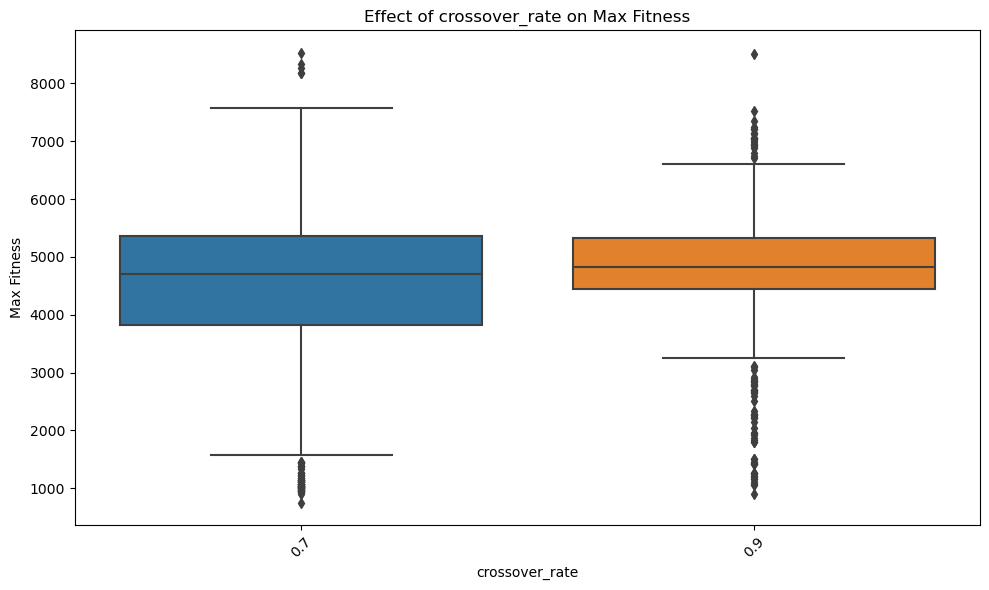

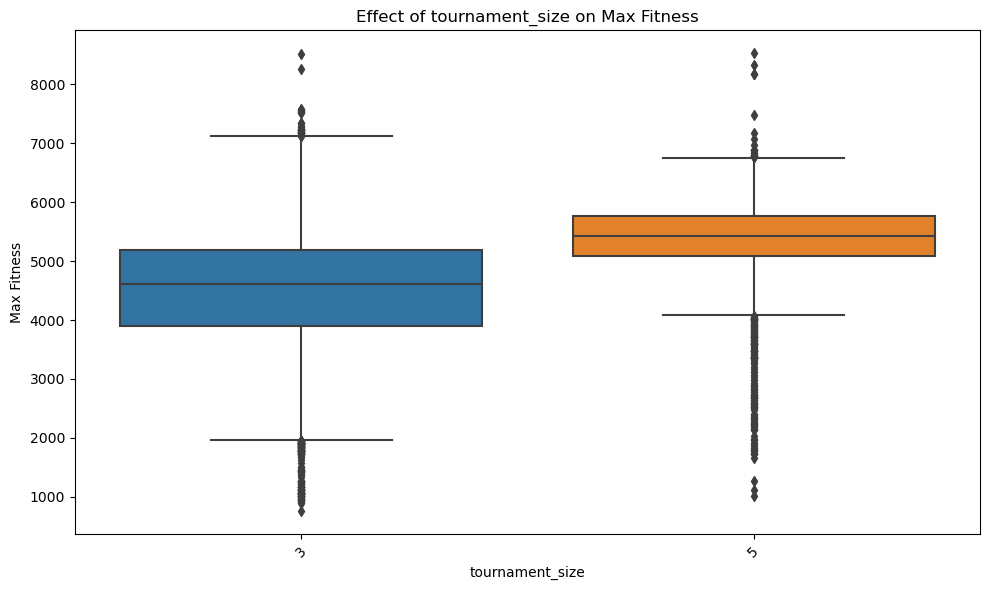

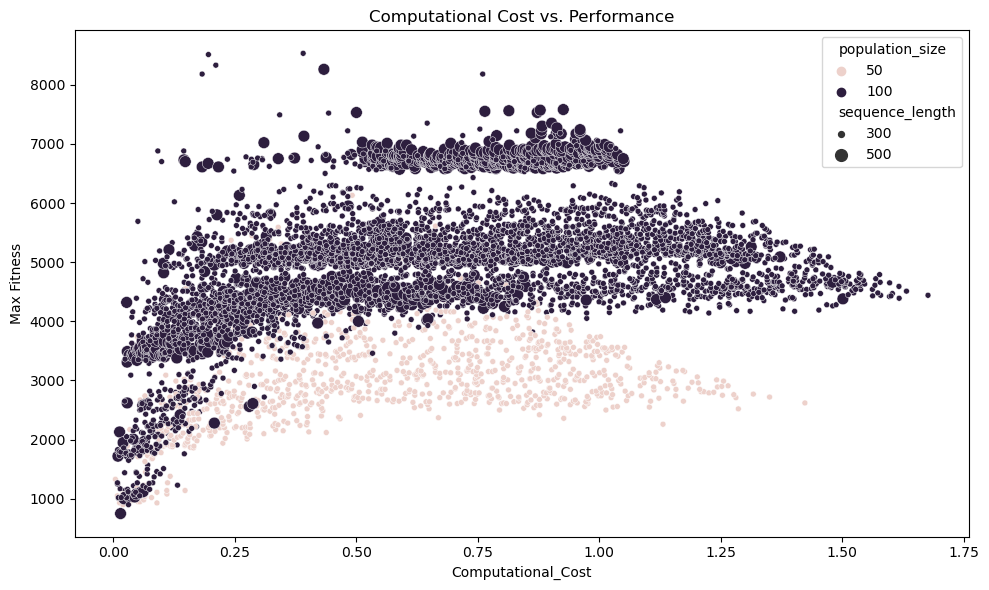

In [8]:
# Additional visualisations
print("\nGenerating additional visualisations...")

# Plot parameter-specific comparisons
parameters_to_analyse = ['population_size', 'sequence_length', 'mutation_rate', 
                        'crossover_rate', 'tournament_size']

for param in parameters_to_analyse:
    if param in analyser.combined_data.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=analyser.combined_data, x=param, y='Max Fitness')
        plt.title(f'Effect of {param} on Max Fitness')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Plot computational efficiency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=analyser.combined_data, 
                x='Computational_Cost', 
                y='Max Fitness', 
                hue='population_size',
                size='sequence_length')
plt.title('Computational Cost vs. Performance')
plt.tight_layout()
plt.show()

In [9]:
# Save analysis results
# Create a timestamp for the analysis

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save summary to CSV
summary_df.to_csv(f'pacman_ga_analysis_summary_{timestamp}.csv', index=False)

# Save statistical analysis results
stats_df = stats_results['parameter_tests']
stats_df.to_csv(f'pacman_ga_statistical_analysis_{timestamp}.csv')

print(f"\nAnalysis results saved with timestamp: {timestamp}")


Analysis results saved with timestamp: 20250131_235942
